<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-heuristics-multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/r-kovalch/acter-ner

Cloning into 'acter-ner'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 562 (delta 34), reused 6 (delta 5), pack-reused 491 (from 1)
Receiving objects: 100% (562/562), 4.98 MiB | 19.83 MiB/s, done.
Resolving deltas: 100% (360/360), done.


In [3]:
!git clone https://github.com/r-kovalch/extractomat.git && cd extractomat/ && git checkout acter && cd ..
#!git clone https://github.com/lang-uk/extractomat.git

Cloning into 'extractomat'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 52 (delta 25), reused 42 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 54.46 KiB | 13.61 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Branch 'acter' set up to track remote branch 'acter' from 'origin'.
Switched to a new branch 'acter'


In [4]:
!git clone https://github.com/AylaRT/ACTER

Cloning into 'ACTER'...
remote: Enumerating objects: 5448, done.
remote: Counting objects: 100% (5448/5448), done.
remote: Compressing objects: 100% (3304/3304), done.
remote: Total 5448 (delta 2684), reused 4893 (delta 2132), pack-reused 0 (from 0)
Receiving objects: 100% (5448/5448), 11.90 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (2684/2684), done.


In [5]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm
!python -m spacy download nl_core_news_sm
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00

In [1]:
import os
import subprocess, sys
from pathlib import Path
from extractomat.matcha import cvalue
import spacy

import numpy as np
import matplotlib.pyplot as plt
from extractomat.tester import TermEvaluator

In [6]:
C_VALUE_MIN_TERMS = 1
C_VALUE_MAX_TERMS = 8
C_VALUE_SMOOTHING = 0.1

In [4]:
root_folder = "content"

language_input_dirs: dict[str, list[str]] = {
    "en": [
        f"/{root_folder}/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "fr": [
        f"/{root_folder}/ACTER/fr/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/fr/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ],
    "nl": [
        f"/{root_folder}/ACTER/nl/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
        f"/{root_folder}/ACTER/nl/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    ]
}
language_output_dirs: dict[str, dict[str, str]] = {
    "en": {
        "train": f"/{root_folder}/en/train_full.tsv",
        "val":   f"/{root_folder}/en/val_full.tsv",
        "test":  f"/{root_folder}/en/dummy_test.tsv",
    },
    "fr": {
        "train": f"/{root_folder}/fr/train_full.tsv",
        "val":   f"/{root_folder}/fr/val_full.tsv",
        "test":  f"/{root_folder}/fr/dummy_test.tsv",
    },
    "nl": {
        "train": f"/{root_folder}/nl/train_full.tsv",
        "val":   f"/{root_folder}/nl/val_full.tsv",
        "test":  f"/{root_folder}/nl/dummy_test.tsv",
    }
}

languages = list(language_input_dirs.keys())

for language in languages:
    io_dirs = language_input_dirs[language]
    train_tsv = Path(language_output_dirs[language]["train"])
    test_tsv  = Path(language_output_dirs[language]["test"])
    val_tsv   = Path(language_output_dirs[language]["val"])

    language_args = [
        "python",
        f"/{root_folder}/acter-ner/term_extractor/preprocess_acter.py",
        "--input_dirs", *io_dirs,
        "--train_output", str(train_tsv),
        "--test_output",  str(test_tsv),
        "--val_output",   str(val_tsv),
        "--test_size", "0.005",
        "--val_size",  "0.195",
        "--seed",      "42",
    ]
    print("⏳ Running:", language)
    subprocess.check_call(language_args)
    print("✅ Splits ready ", train_tsv, ",", val_tsv, ", and", test_tsv)


⏳ Running: en
✅ Splits ready  /content/en/train_full.tsv , /content/en/val_full.tsv , and /content/en/dummy_test.tsv
⏳ Running: fr
✅ Splits ready  /content/fr/train_full.tsv , /content/fr/val_full.tsv , and /content/fr/dummy_test.tsv
⏳ Running: nl
✅ Splits ready  /content/nl/train_full.tsv , /content/nl/val_full.tsv , and /content/nl/dummy_test.tsv


In [ ]:
language_nlp_models: dict[str, str] = {
    "en": "en_core_web_sm",
    "fr": "fr_core_news_sm",
    "nl": "nl_core_news_sm"
}
c_value_results: dict[str, dict] = {
    "en": {
        "train": {},
        "val":   {},
        "test":  {}
    },
    "fr": {
        "train": {},
        "val":   {},
        "test":  {},
    },
    "nl": {
        "train": {},
        "val":   {},
        "test":  {},
    },
}

for language in languages:
    nlp = spacy.load(language_nlp_models[language], disable=["ner"])
    nlp.max_length = 1500000

    for subset in c_value_results[language].keys():
        subset_tsv = Path(language_output_dirs[language][subset])
        doc = nlp(Path(os.path.join(subset_tsv.with_suffix(''), "text.txt")).read_text().lower())

        term_scores, term_occ = cvalue(
            doc,
            n_min=C_VALUE_MIN_TERMS,
            n_max=C_VALUE_MAX_TERMS,
            smoothing=C_VALUE_SMOOTHING,
        )

        c_value_results[language][subset] = {
            "term_scores": term_scores,
            "term_occ":    term_occ
        }

        print(f"Extracted {len(term_scores):,} candidate terms for {subset} for {language}")


Extracted 30,554 candidate terms for train for en
Extracted 10,091 candidate terms for val for en
Extracted 563 candidate terms for test for en
Extracted 14,750 candidate terms for train for fr
Extracted 5,537 candidate terms for val for fr
Extracted 368 candidate terms for test for fr


In [ ]:
def _sweep(evaluator, scores, points=100):
    t_min, t_max = scores.min(), scores.max()
    abs_t = np.linspace(t_min - 1e-9, t_max, points)
    norm_t = (abs_t - t_min) / (t_max - t_min)
    P = R = F = np.zeros(points)
    for i, t in enumerate(abs_t):
        try:
            P[i], R[i], F[i] = evaluator.calculate_metrics(t)
        except ZeroDivisionError:
            pass
    best_i = np.argmax(F)
    return norm_t, P, R, F, best_i

def _plot_one(lang, subset, gt_csv, t_scores, t_occ):
    ev = TermEvaluator(gt_csv, t_scores, t_occ, method="cvalue", language=lang)
    n_t, P, R, F, best = _sweep(ev, np.array(list(t_scores.values())))
    fig, ax = plt.subplots(1, 3, figsize=(11, 3), dpi=150, sharex=True)
    for a, y, lbl in zip(ax, (P, R, F), ("Precision", "Recall", "F1")):
        a.plot(n_t, y)
        a.set_title(lbl)
        a.grid(True, linewidth=.4)
    ax[1].set_xlabel("Normalised threshold")
    fig.suptitle(f"{lang.upper()} • {subset}")
    plt.tight_layout()
    print(f"{lang.upper()} {subset}:  P={P[best]:.3f}  R={R[best]:.3f}  F1={F[best]:.3f}")

for lang, subsets in c_value_results.items():
    for subset, data in subsets.items():
        if not data:              # skip empty slots
            continue
        gt_file = GT_CSVS[lang][subset]   # provide your gold-label TSV paths here
        _plot_one(lang, subset,
                  gt_file,
                  data["term_scores"],
                  data["term_occ"])


In [ ]:
for language in languages:
    for subset in c_value_results[language].keys():
        gt_csv = Path(os.path.join(Path(language_output_dirs[language][subset]).with_suffix(""), "gt_labels.csv"))
        term_scores = c_value_results[language][subset]["term_scores"]
        term_occ = c_value_results[language][subset]["term_occ"]

        evaluator = TermEvaluator(
            gt_csv,
            term_scores,
            term_occ,
            method="cvalue",
            language=language
        )

        scores = np.array(list(term_scores.values()))
        t_min, t_max = scores.min(), scores.max()
        thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

        best = {"f1": -1.0}

        for t in thresholds:
            try:
                p, r, f1 = evaluator.calculate_metrics(t)
            except ZeroDivisionError:
                # no candidates or no GT terms at this t → skip
                continue
            if f1 > best["f1"]:
                best.update(threshold=t, precision=p, recall=r, f1=f1)

In [ ]:
import numpy as np
from extractomat.tester import TermEvaluator

evaluator = TermEvaluator(
    GT_CSV,
    term_scores,          # from Cell 5
    term_occ,             # from Cell 5
    method="cvalue",
    language="en"
)

scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}

for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        # no candidates or no GT terms at this t → skip
        continue
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)

    import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

# original score range
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()

# generate absolute thresholds, then normalize
abs_thresholds = np.linspace(t_min - 1e-9, t_max, num=100)
norm_thresholds = (abs_thresholds - t_min) / (t_max - t_min)

precisions, recalls, f1_scores = [], [], []
for t in abs_thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# convert to arrays
precisions = np.array(precisions)
recalls    = np.array(recalls)
f1_scores  = np.array(f1_scores)

# find best F1 index
best_idx = np.argmax(f1_scores)
best = {
    'threshold_norm': norm_thresholds[best_idx],
    'precision':     precisions[best_idx],
    'recall':        recalls[best_idx],
    'f1':            f1_scores[best_idx]
}

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(norm_thresholds, precisions, label="Precision")
plt.plot(norm_thresholds, recalls,    label="Recall")
plt.plot(norm_thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Normalized Threshold (0–1)")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Normalized Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ── best result ────────────────────────────────────────────────────────────
print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold_norm']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

# original score range
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()

# generate absolute thresholds, then normalize
abs_thresholds = np.linspace(t_min - 1e-9, t_max, num=100)
norm_thresholds = (abs_thresholds - t_min) / (t_max - t_min)

precisions, recalls, f1_scores = [], [], []
for t in abs_thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# convert to arrays
precisions = np.array(precisions)
recalls    = np.array(recalls)
f1_scores  = np.array(f1_scores)

# find best F1 index
best_idx = np.argmax(f1_scores)
best = {
    'threshold_norm': norm_thresholds[best_idx],
    'precision':     precisions[best_idx],
    'recall':        recalls[best_idx],
    'f1':            f1_scores[best_idx]
}

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(norm_thresholds, precisions, label="Precision")
plt.plot(norm_thresholds, recalls,    label="Recall")
plt.plot(norm_thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Normalized Threshold (0–1)")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Normalized Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ── best result ────────────────────────────────────────────────────────────
print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold_norm']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")


In [ ]:
(1.16507 - t_min) / (t_max - t_min)

1.1976341730545883

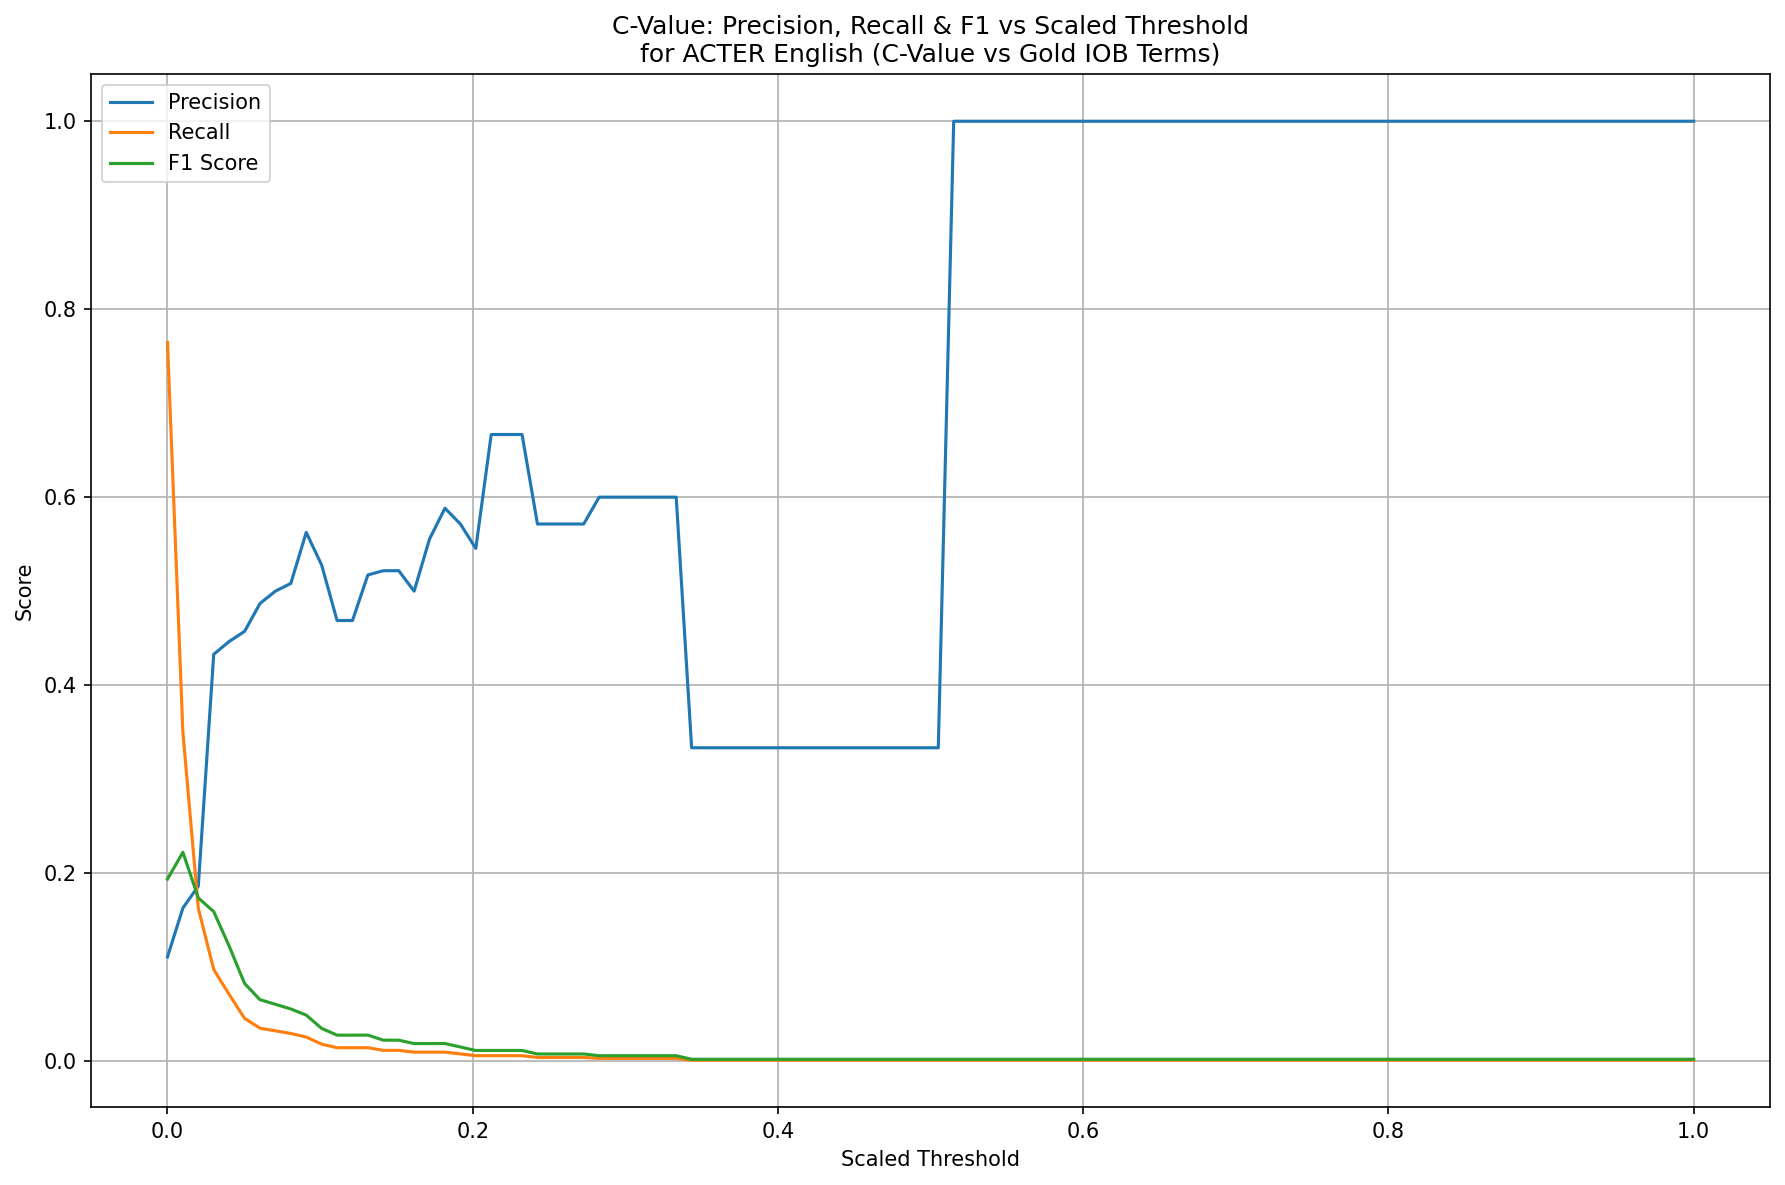

In [ ]:
# prompt: generate a min max scaling for treshold based on t_min and t_max

import matplotlib.pyplot as plt
scaled_thresholds = (thresholds - t_min) / (t_max - t_min)

# You can now use `scaled_thresholds` for plotting or further analysis
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(scaled_thresholds, precisions, label="Precision")
plt.plot(scaled_thresholds, recalls,    label="Recall")
plt.plot(scaled_thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Scaled Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Scaled Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from extractomat.sbert_reranker import SentenceSimilarityCalculator

# ── load torch & SBERT (GPU if available) ─────────────────────────────────
import torch
from sentence_transformers import SentenceTransformer  # imported for completeness

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 SBERT device → {device}")

# ── instantiate the reranker correctly ────────────────────────────────────
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

# ── re-rank your C-Value candidates ───────────────────────────────────────
reranked_scores = reranker.rerank_terms_in_doc(
    doc,             # spaCy Doc from C-Value step
    term_occ,        # occurrences dict from C-Value step
    context_len=3,
    pooling="max"
)
print(f"✅ Re-ranked {len(reranked_scores):,} terms")

🔧 SBERT device → cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Re-ranked 24,906 terms


Best ReRank results (threshold sweep):
   threshold = 0.84108
   precision = 0.171
   recall    = 0.587
   F1        = 0.265


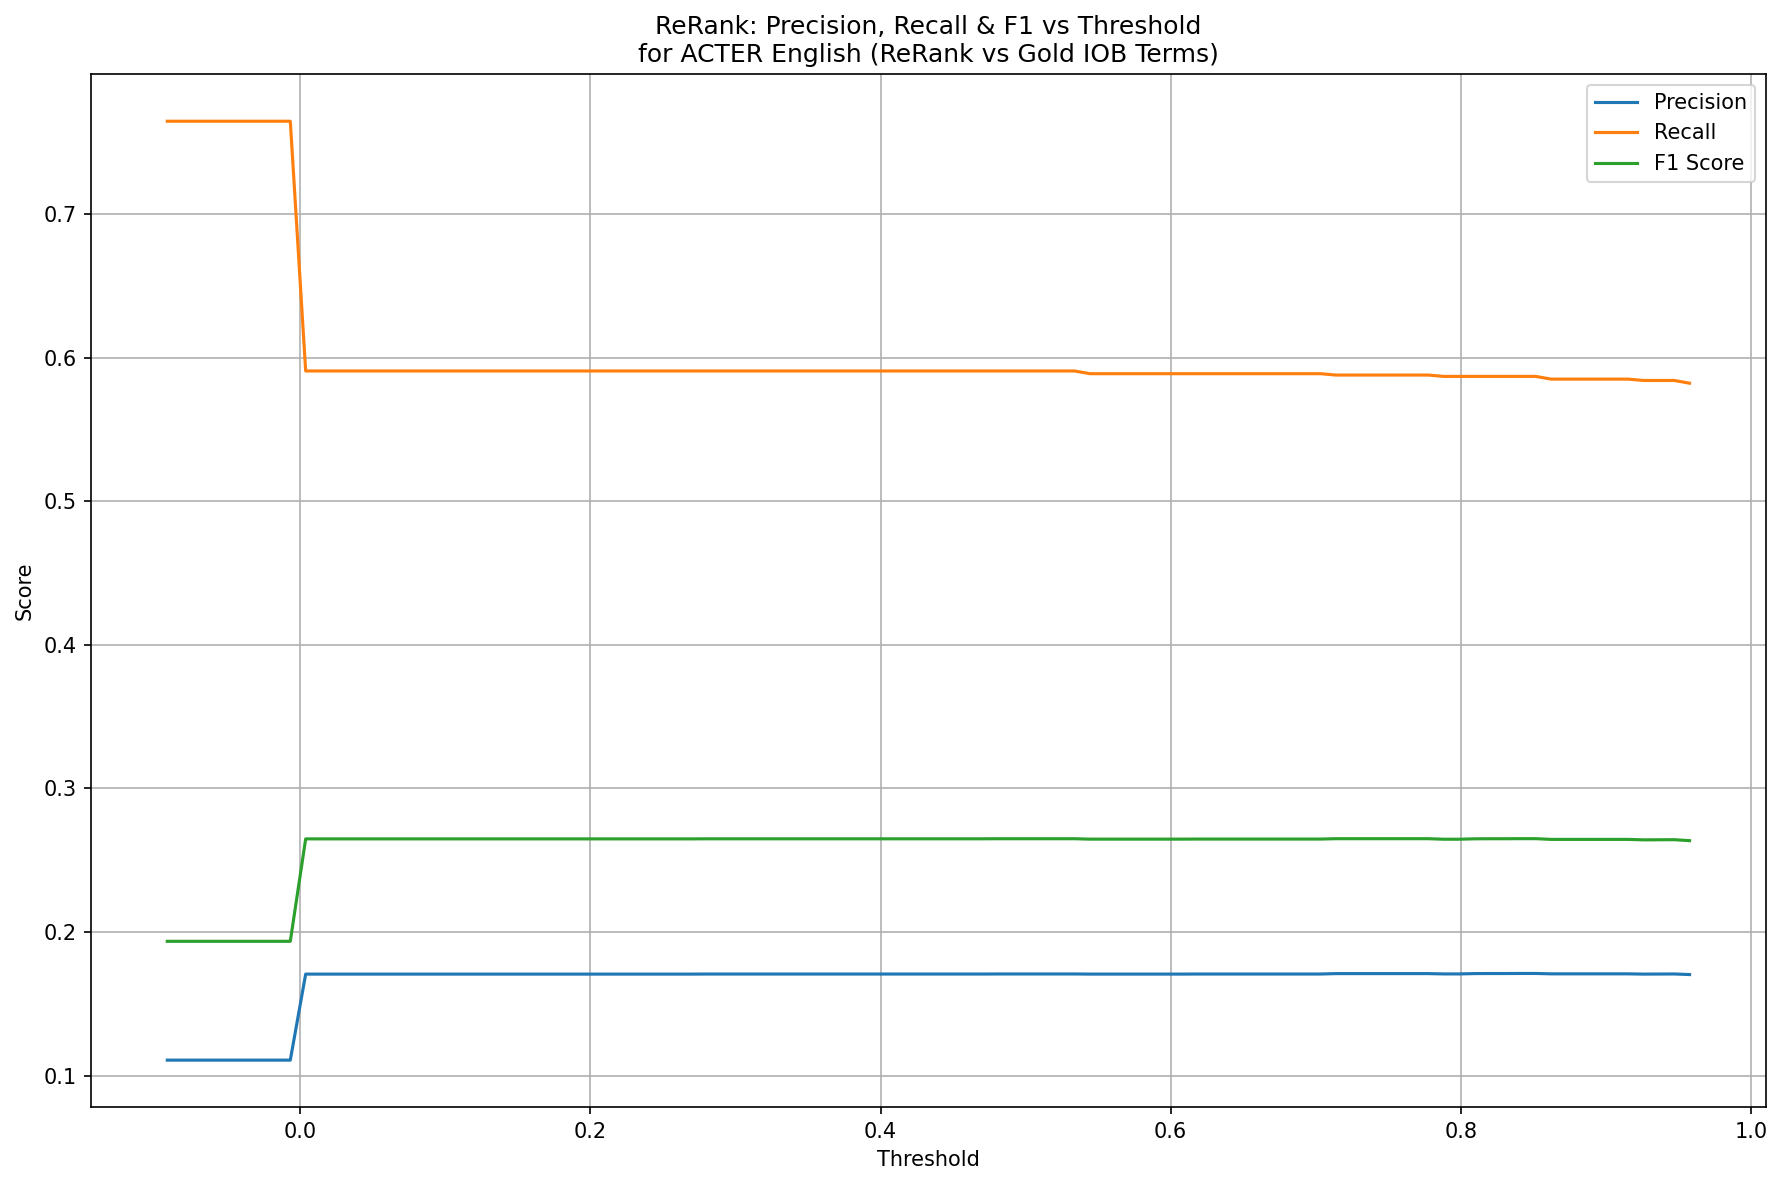

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

r_scores = np.array(list(reranked_scores.values()))
t_min, t_max = r_scores.min(), r_scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# convert to numpy arrays for easy indexing
precisions = np.array(precisions)
recalls    = np.array(recalls)
f1_scores  = np.array(f1_scores)

# find the index of the best F1 score
best_idx = np.argmax(f1_scores)

# print best-results block
print("Best ReRank results (threshold sweep):")
print(f"   threshold = {thresholds[best_idx]:.5f}")
print(f"   precision = {precisions[best_idx]:.3f}")
print(f"   recall    = {recalls[best_idx]:.3f}")
print(f"   F1        = {f1_scores[best_idx]:.3f}")

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("ReRank: Precision, Recall & F1 vs Threshold\nfor ACTER English (ReRank vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


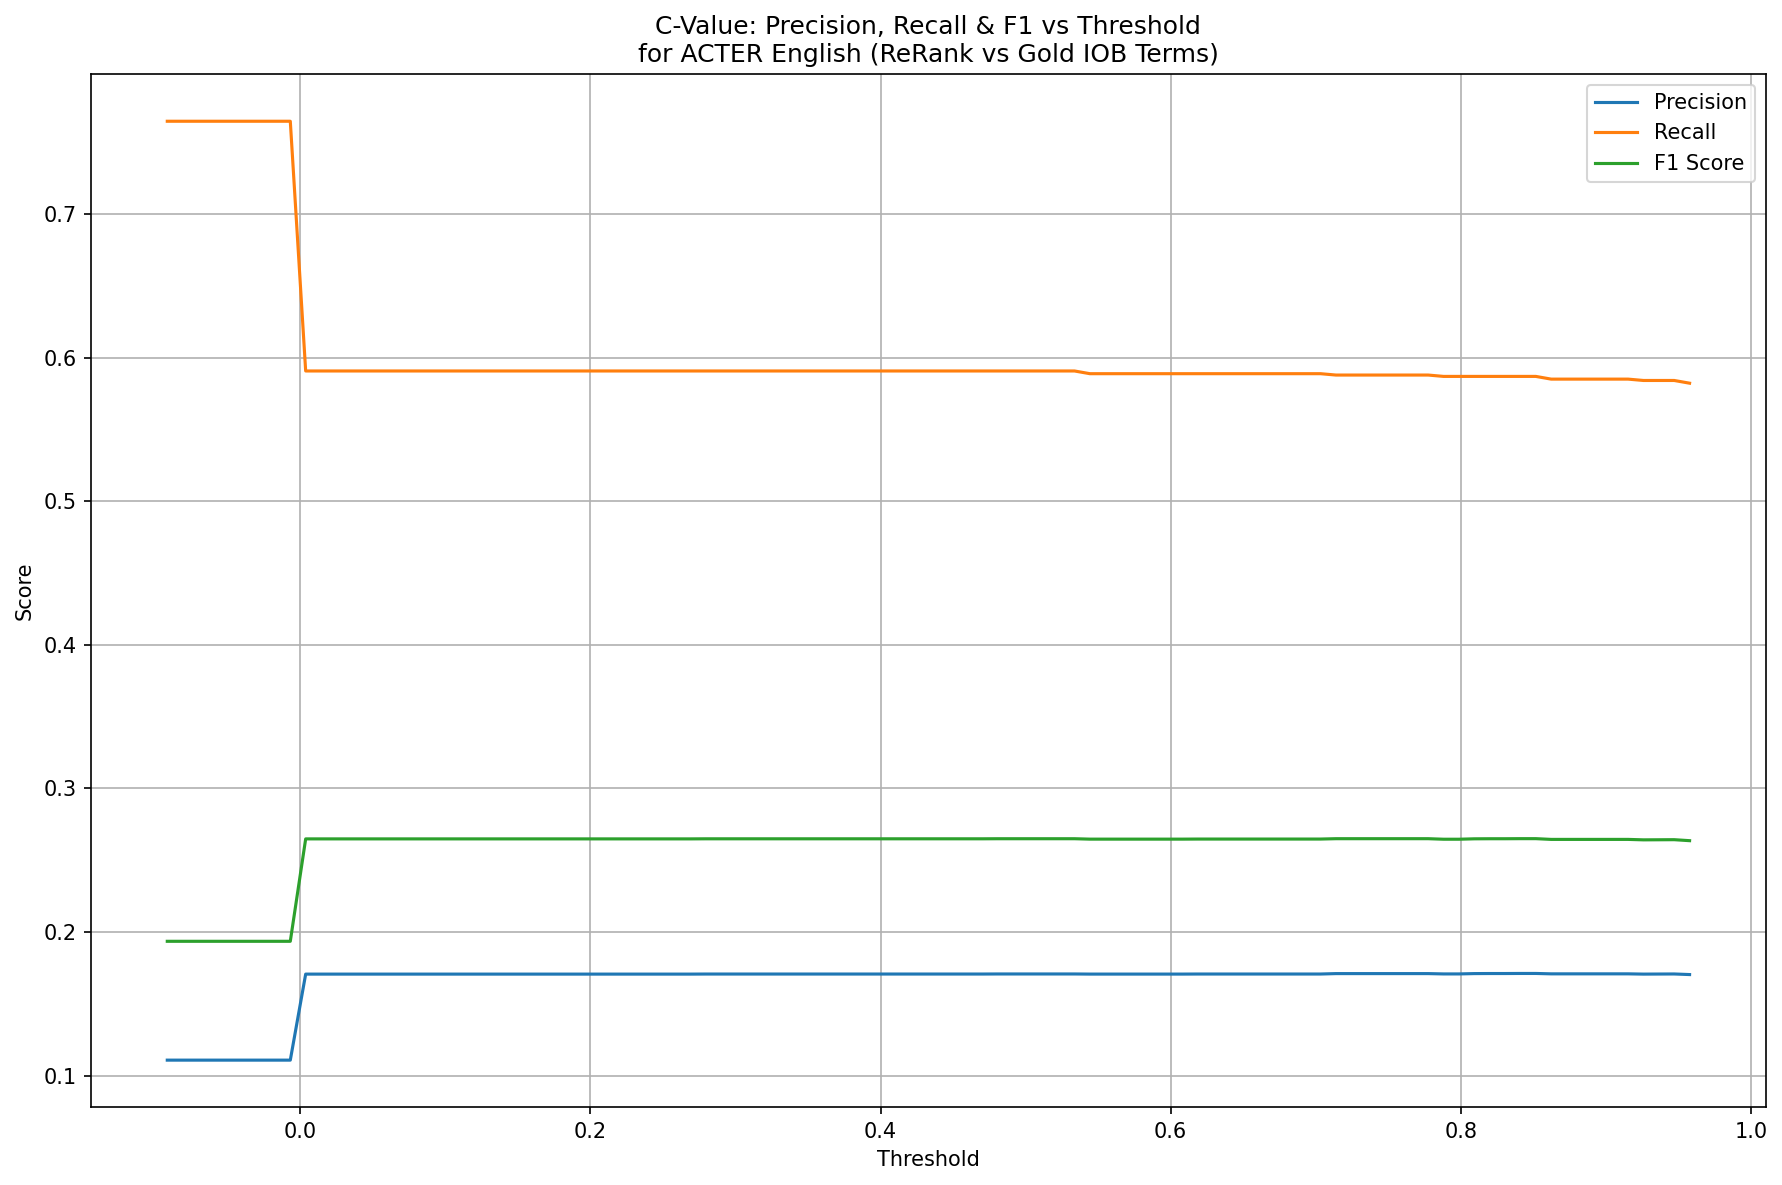

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path

r_scores = np.array(list(reranked_scores.values()))
t_min, t_max = r_scores.min(), r_scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (ReRank vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:


# ── rebuild gold terms from IOB validation split (val_full.tsv) ──────────
val_tsv = Path("val_full.tsv")
gold_terms = set()
current = []

for line in val_tsv.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
        continue
    token, label = line.split("\t")
    if label.startswith("B"):
        if current:
            gold_terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        current.append(token)
    else:
        if current:
            gold_terms.add(" ".join(current).lower())
            current = []
if current:
    gold_terms.add(" ".join(current).lower())

print(f"🎯 Loaded {len(gold_terms):,} gold terms")

🎯 Loaded 2,172 gold terms


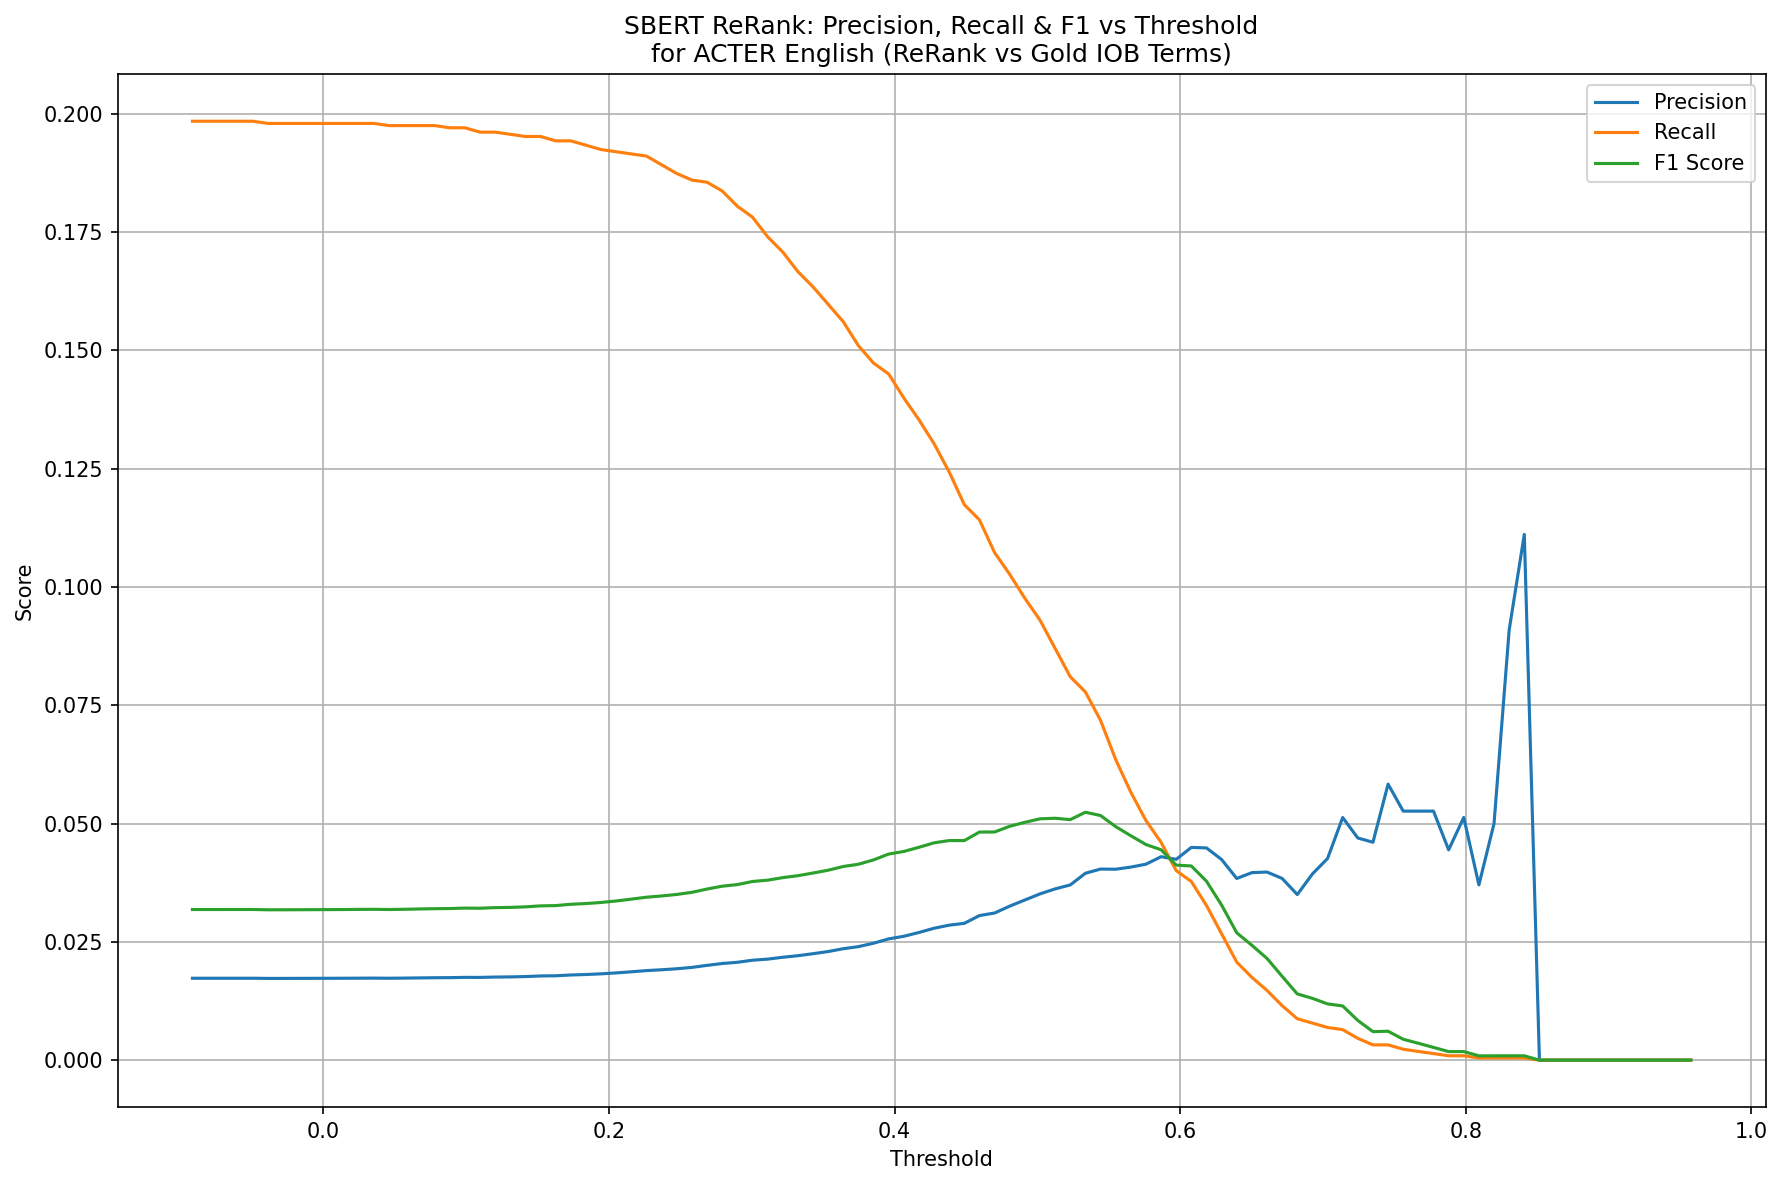

▶ Best ReRanked Results:
   threshold = 0.53368
   precision = 0.039
   recall    = 0.078
   F1        = 0.052


In [ ]:
scores = np.array(list(reranked_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plot Precision, Recall & F1 vs Threshold ─────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(
    "SBERT ReRank: Precision, Recall & F1 vs Threshold\n"
    "for ACTER English (ReRank vs Gold IOB Terms)"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
scores_arr = np.array(list(reranked_scores.values()))
t_min, t_max = scores_arr.min(), scores_arr.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}
for t in thresholds:
    preds = {term for term, sc in reranked_scores.items() if sc >= t}
    tp = len(preds & gold_terms)
    p = tp / len(preds) if preds else 0.0
    r = tp / len(gold_terms) if gold_terms else 0.0
    f1 = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)

print("▶ Best ReRanked Results:")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")

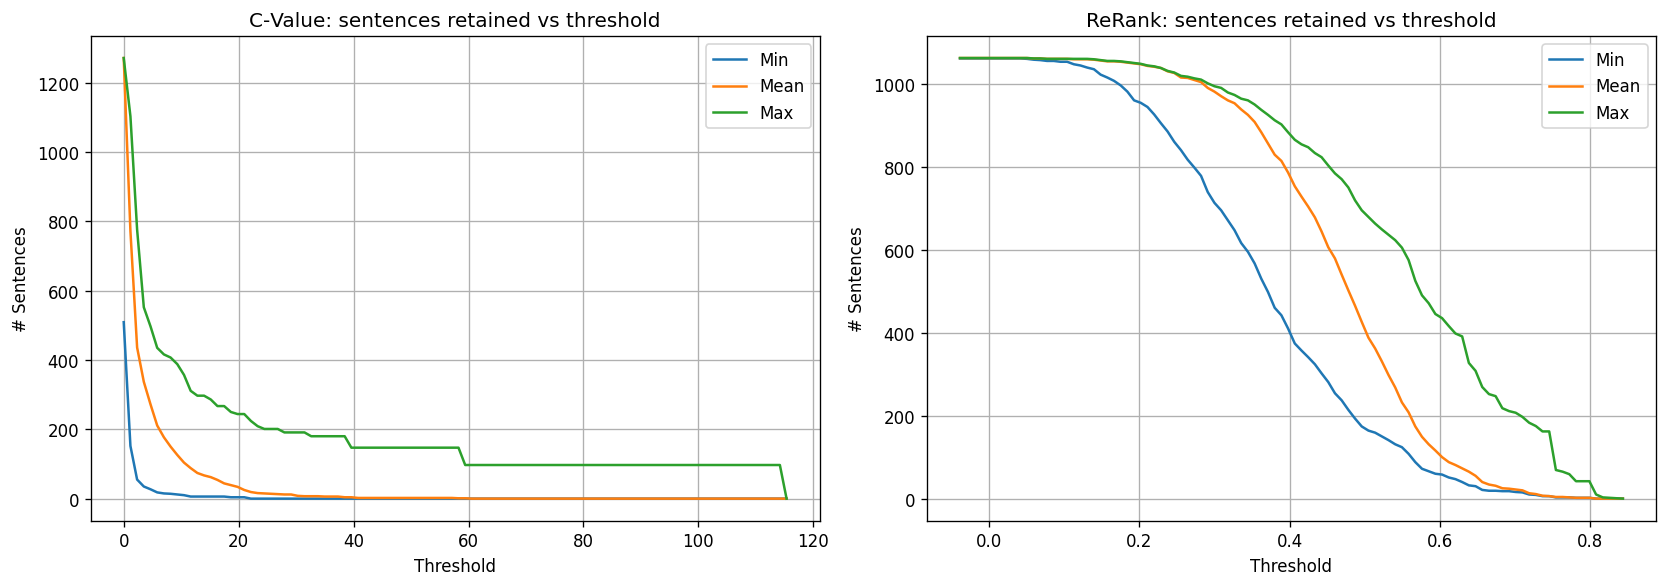

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------------------------------------------------------------------------
# This cell assumes term_scores, term_occ, and reranked_scores are already
# defined from your earlier C‑Value and ReRank steps.
# ---------------------------------------------------------------------------

# 1) Bucket all scores that belong to each sentence
bucket_c, bucket_r = defaultdict(list), defaultdict(list)

for term, spans in term_occ.items():
    c_val = term_scores[term]
    r_val = reranked_scores.get(term, None)
    for span in spans:
        s = span.sent  # spaCy sentence object
        bucket_c[s].append(c_val)
        if r_val is not None:
            bucket_r[s].append(r_val)

# 2) Compute per‑sentence min / mean / max
def per_sentence_stats(bucket):
    mins, means, maxs = [], [], []
    for scores in bucket.values():
        mins.append(min(scores))
        means.append(np.mean(scores))
        maxs.append(max(scores))
    return np.array(mins), np.array(means), np.array(maxs)

c_min, c_mean, c_max = per_sentence_stats(bucket_c)
r_min, r_mean, r_max = per_sentence_stats(bucket_r)

stat_arrays = {
    "C-Value": {"min": c_min, "mean": c_mean, "max": c_max},
    "ReRank":  {"min": r_min, "mean": r_mean, "max": r_max}
}

# 3) Threshold ranges (use overall min/max of each method)
thr_c = np.linspace(c_min.min(), c_max.max(), 100)
thr_r = np.linspace(r_min.min(), r_max.max(), 100)

# 4) Compute sentence counts (not rates) above each threshold
cnt_c = {stat: [int((arr > t).sum()) for t in thr_c]
         for stat, arr in stat_arrays["C-Value"].items()}
cnt_r = {stat: [int((arr > t).sum()) for t in thr_r]
         for stat, arr in stat_arrays["ReRank"].items()}

# 5) Plot: #sentences retained vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

for stat in ["min", "mean", "max"]:
    ax1.plot(thr_c, cnt_c[stat], label=f"{stat.capitalize()}")
    ax2.plot(thr_r, cnt_r[stat], label=f"{stat.capitalize()}")

ax1.set_title("C‑Value: sentences retained vs threshold")
ax1.set_xlabel("Threshold"); ax1.set_ylabel("# Sentences")
ax1.grid(True); ax1.legend()

ax2.set_title("ReRank: sentences retained vs threshold")
ax2.set_xlabel("Threshold"); ax2.set_ylabel("# Sentences")
ax2.grid(True); ax2.legend()

plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Cell 7 – Compute per-sentence confidence and plot retention vs threshold

# Choose scores: prefer reranked_scores if available, else fallback to term_scores
scores_dict = globals().get('reranked_scores') or globals().get('term_scores')
occ_dict = globals().get('term_occ')

# Sanity check
assert scores_dict is not None and occ_dict is not None, \
    "Error: term_scores/term_occ or reranked_scores/term_occ not found in memory."

# Map each sentence to the list of term scores within it
sent_scores = defaultdict(list)
for term, spans in occ_dict.items():
    score = scores_dict[term]
    for span in spans:
        sent = span.sent  # spaCy Span.sent property gives the sentence
        sent_scores[sent].append(score)

# Compute confidence per sentence as the max score of its term predictions
sent_conf = {sent: max(scores) for sent, scores in sent_scores.items()}

# Prepare retention data for threshold sweep
conf_values = np.array(list(sent_conf.values()))
t_min, t_max = conf_values.min(), conf_values.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=50)
retentions = [sum(1 for c in conf_values if c >= t) for t in thresholds]

# Plot retention curve
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, retentions)
plt.xlabel("Confidence Threshold")
plt.ylabel("Number of Sentences Retained")
plt.title("Retention Curve: Sentences Retained vs Confidence Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display a few example sentences above the median confidence
median_conf = np.median(conf_values)
kept = [sent for sent, c in sent_conf.items() if c >= median_conf]
print(f"Sample sentences with confidence ≥ {median_conf:.3f}:")
for sent in kept[:5]:
    print(" -", sent.text)


KeyError: 'intense movement'

In [ ]:
# Compute sentence-level confidences for both methods
sent_scores_c = defaultdict(list)
sent_scores_r = defaultdict(list)
for term, spans in term_occ.items():
    score_c = term_scores[term]
    score_r = reranked_scores[term]
    for span in spans:
        sent = span.sent
        sent_scores_c[sent].append(score_c)
        sent_scores_r[sent].append(score_r)
sent_conf_c = {s: max(lst) for s, lst in sent_scores_c.items()}
sent_conf_r = {s: max(lst) for s, lst in sent_scores_r.items()}

KeyError: 'intense movement'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Build thresholds over the union of both domains
all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
t_min, t_max = all_confs.min(), all_confs.max()
thresholds = np.linspace(t_min, t_max, num=5000)

ret_c = [(np.sum(list(sent_conf_c.values()) >= t)) for t in thresholds]
ret_r = [(np.sum(list(sent_conf_r.values()) >= t)) for t in thresholds]


plt.figure(figsize=(10, 6), dpi=120)
plt.xlim(0, 25)
plt.plot(thresholds, ret_c, label="C-Value retention")
plt.plot(thresholds, ret_r, label="ReRank retention")
plt.xlabel("Confidence Threshold")
plt.ylabel("Sentences Retained")
plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'sent_conf_c' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes sent_conf_c, sent_conf_r, and doc are already in memory
assert 'sent_conf_c' in globals() and 'sent_conf_r' in globals(), "Run the confidence computation cell first"
assert 'doc' in globals(), "Run the C-Value extraction cell to define `doc`"

# Fixed thresholds for each method
threshold_c = 2.25  # C-Value cutoff
threshold_r = 0.4  # ReRank cutoff

# Build fine-grained thresholds over observed confidence ranges
all_confs = np.concatenate([list(sent_conf_c.values()), list(sent_conf_r.values())])
t_min, t_max = all_confs.min(), all_confs.max()
thresholds = np.linspace(t_min, t_max, num=5000)

# Compute retention counts at each threshold
ret_c = np.array([np.sum(np.array(list(sent_conf_c.values())) >= t) for t in thresholds])
ret_r = np.array([np.sum(np.array(list(sent_conf_r.values())) >= t) for t in thresholds])

# Plot retention curves
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, ret_c, label="C-Value retention")
plt.plot(thresholds, ret_r, label="ReRank retention")

# Limit x-axis and add vertical threshold lines
plt.xlim(0, 25)
plt.axvline(threshold_c, color='pink', linestyle='--', label=f"C-Value threshold = {threshold_c}")
plt.axvline(threshold_r, color='red', linestyle='--', label=f"ReRank threshold = {threshold_r}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Sentences Retained")
plt.title("Sentence Retention vs Threshold\nC-Value vs ReRank")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print percentages of sentences retained
total_sents = len(list(doc.sents))
retained_c = np.sum(np.array(list(sent_conf_c.values())) >= threshold_c)
retained_r = np.sum(np.array(list(sent_conf_r.values())) >= threshold_r)
pct_c = retained_c / total_sents * 100
pct_r = retained_r / total_sents * 100

print(f"C-Value threshold {threshold_c}: retained {retained_c}/{total_sents} sentences ({pct_c:.2f}%)")
print(f"ReRank threshold {threshold_r}: retained {retained_r}/{total_sents} sentences ({pct_r:.2f}%)")


AssertionError: Run the confidence computation cell first

In [ ]:
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm
import sys, os

# ── ensure extractomat is importable ───────────────────────────────────────
sys.path.insert(0, os.path.join(os.getcwd(), "extractomat"))

# ── preconditions ─────────────────────────────────────────────────────────
assert 'doc' in globals(), "Please re-run C-Value extraction to define `doc`."
assert 'term_occ' in globals(), "Please re-run C-Value extraction to define `term_occ`."
assert 'term_scores' in globals(), "Please re-run C-Value extraction to define `term_scores`."
assert 'reranked_scores' in globals(), "Please re-run SBERT ReRank to define `reranked_scores`."

# ── map sentences to their spans with scores ──────────────────────────────
sent2spans = defaultdict(list)
for term, spans in term_occ.items():
    sc = term_scores[term]
    sr = reranked_scores[term]
    for span in spans:
        # find parent sentence by boundaries
        for sent in doc.sents:
            if span.start >= sent.start and span.end <= sent.end:
                sent2spans[sent].append((span, sc, sr))
                break

# ── prepare sentences ───────────────────────────────────────────────────────
sentences = list(doc.sents)

# ── define splits and their inclusion functions ────────────────────────────
splits = {
    "train_cvalue_original.tsv":       lambda spans: True,
    f"train_cvalue_conf{threshold_c}.tsv": lambda spans: max((sc for _, sc, _ in spans), default=0) >= threshold_c,
    "train_rerank_original.tsv":       lambda spans: True,
    f"train_rerank_conf{threshold_r}.tsv": lambda spans: max((sr for _, _, sr in spans), default=0) >= threshold_r,
}

# ── output directory ───────────────────────────────────────────────────────
output_dir = Path("/content/drive/MyDrive/ucu/ner/datasets")
output_dir.mkdir(exist_ok=True)


# ── generate each file with stats logging ─────────────────────────────────
for fname, keep_fn in splits.items():
    out_path = output_dir / fname
    b_count = i_count = o_count = blank_count = 0
    with out_path.open("w", encoding="utf-8") as fout:
        for sent in tqdm(sentences, desc=f"Writing {fname}", unit="sent"):
            spans = sent2spans.get(sent, [])
            if not keep_fn(spans):
                continue

            # initialize labels
            labels = ["O"] * len(sent)
            # assign B/I labels for spans above threshold
            for span, sc, sr in spans:
                score = sc if "cvalue" in fname else sr
                thresh = threshold_c if "cvalue" in fname else threshold_r
                if score < thresh:
                    continue
                start = span.start - sent.start
                end   = span.end   - sent.start
                labels[start] = "B"
                for j in range(start+1, end):
                    labels[j] = "I"

            # write tokens and count labels
            for token, lbl in zip(sent, labels):
                if lbl == "O":
                    o_count += 1
                    fout.write(f"{token.text}\tO\n")
                else:
                    if lbl == "B":
                        b_count += 1
                        fout.write(f"{token.text}\tB-TERM\n")
                    else:
                        i_count += 1
                        fout.write(f"{token.text}\tI-TERM\n")
            # end of sentence
            fout.write("\n")
            blank_count += 1

    print(f"✓ Wrote {out_path.name}")
    print(f"  → Sentences (blanks): {blank_count}")
    print(f"  → B-TERM tokens:     {b_count}")
    print(f"  → I-TERM tokens:     {i_count}")
    print(f"  → O tokens:          {o_count}\n")


In [ ]:
from google.colab import runtime
runtime.unassign()